# Classifying Knee Images

## 1 Imports

In [ ]:
# omit tensorflow import futurewarnings
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
print('TensorFlow version: ', tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D

from tensorflow import keras
from tensorflow.keras import Model, preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

TensorFlow version:  2.5.0


## 2 Load the data

## 2.1 Different setup criteria
Code will differ based on whether we are running on Google Colab or on a local machine

### 2.1.1 On local machine

In [ ]:
# directory = "../data/"

### 2.1.2 On Google Colab

In [ ]:
!wget --no-check-certificate \
    "https://github.com/fontainelam/KneeOsteoarthritis/archive/refs/heads/main.zip" \
    -O "/tmp/knee-data.zip"

zip_ref = zipfile.ZipFile('/tmp/knee-data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2021-06-14 06:22:08--  https://github.com/fontainelam/KneeOsteoarthritis/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/fontainelam/KneeOsteoarthritis/zip/refs/heads/main [following]
--2021-06-14 06:22:09--  https://codeload.github.com/fontainelam/KneeOsteoarthritis/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/knee-data.zip’

/tmp/knee-data.zip      [               <=>  ] 173.27M  47.2MB/s    in 3.7s    

2021-06-14 06:22:13 (46.2 MB/s) - ‘/tmp/knee-data.zip’ saved [181691052]



In [ ]:
!ls /tmp/KneeOsteoarthritis-main/data/

test  train  val


In [ ]:
os.listdir("/tmp/KneeOsteoarthritis-main/data/")

['train', 'val', 'test']

In [ ]:
directory = "/tmp/KneeOsteoarthritis-main/data/"

## 2.2 Load files

In [ ]:
train_directory = directory + "train"
test_directory = directory + "test"
val_directory = directory + "val"

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

def fetch_image_data_from_directory( dir_path, shuffle ):
    return image_dataset_from_directory(
    dir_path,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    smart_resize=False,
)

In [ ]:
train_dataset = fetch_image_data_from_directory(train_directory, True)

Found 5778 files belonging to 5 classes.


In [ ]:
val_dataset = fetch_image_data_from_directory(val_directory, True)

Found 826 files belonging to 5 classes.


In [ ]:
test_dataset = fetch_image_data_from_directory(test_directory, False) # no need to shuffle the test dataset

Found 1656 files belonging to 5 classes.


In [ ]:
def fetch_files_from_directory( dir_path ):
  file_dict = {}
  for grade in os.listdir( dir_path ):
    file_dict[grade] = os.listdir(dir_path + '/' + grade)
  return file_dict

In [ ]:
train_files = fetch_files_from_directory(train_directory)
val_files = fetch_files_from_directory(val_directory)
test_files = fetch_files_from_directory(test_directory)

## 3 Explore the data

In [ ]:
print('Training data: ', train_dataset.element_spec)
print('Validation data: ', val_dataset.element_spec)
print('Testing data: ', test_dataset.element_spec)

Training data:  (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Validation data:  (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Testing data:  (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [ ]:
sns.set_style("dark")

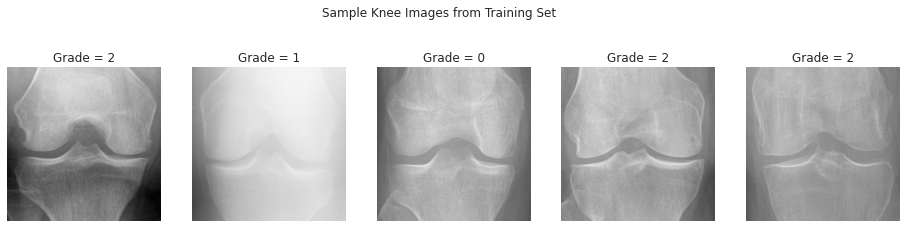

In [ ]:
plt.figure(figsize=(16, 4))
for images, labels in train_dataset.take(1):
    for i in range(5):
        ax = plt.subplot(1,5,i+1)
        ax.axis('off')
        plt.imshow(images[i].numpy().squeeze().astype('uint8'),cmap='gray')
        ax.set_title('Grade = ' + str(labels[i].numpy()))
_ = plt.suptitle('Sample Knee Images from Training Set')

In [ ]:
def plot_distribution(set_of_files, title):
    f, ax = plt.subplots(figsize=(16,6))
    keys = sorted(list(set_of_files.keys()))
    vals = [len(set_of_files[k]) for k in keys]
    sns.barplot(x=keys, y=vals, palette="Blues_d")
    plt.xlabel('Knee Severity Grade')
    plt.title(title)

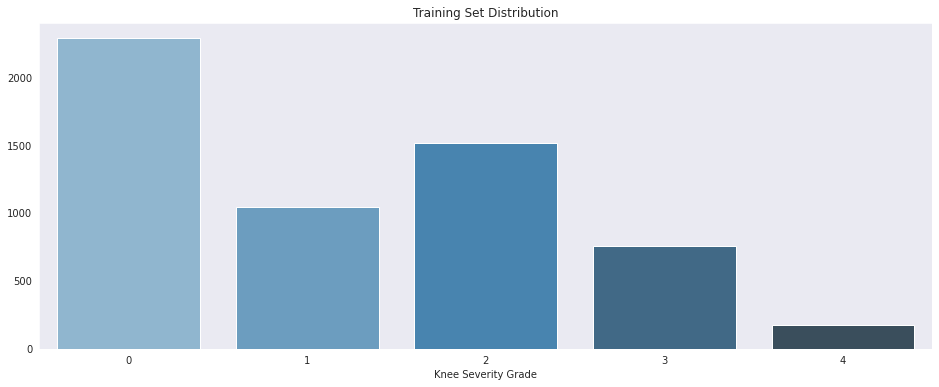

In [ ]:
plot_distribution(train_files, 'Training Set Distribution')

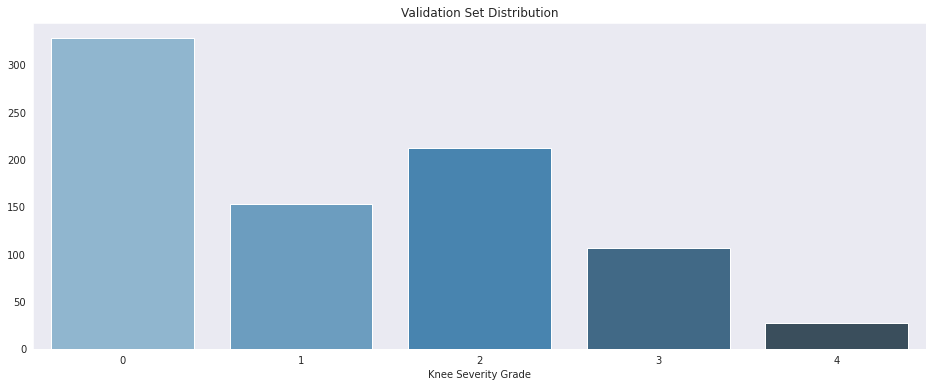

In [ ]:
plot_distribution(val_files, 'Validation Set Distribution')

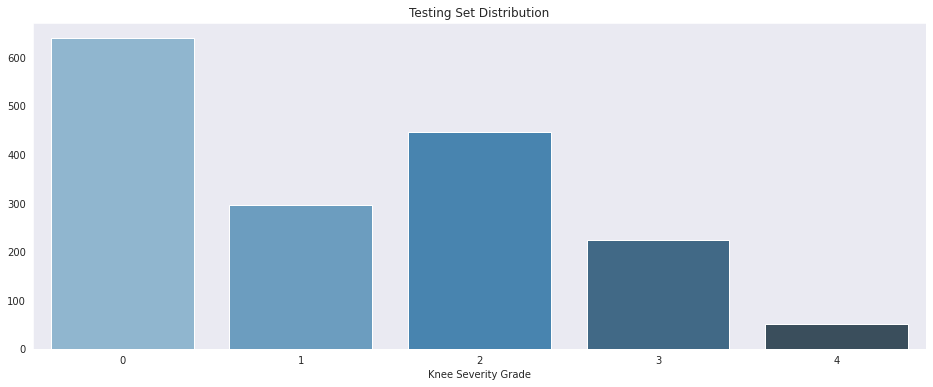

In [ ]:
plot_distribution(test_files, 'Testing Set Distribution')

## 4 Model

### 4.1 Building the model

__Transfer learning__

In [ ]:
img_height = 224
img_width = 224

base_model = DenseNet201(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = GlobalAveragePooling2D()(x)

num_classes = 5

outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 9605      
Total params: 18,331,589
Trainable params: 9,605
Non-trainable params: 18,321,984
_________________________________________________________________


In [26]:
num_epochs = 6
history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

Epoch 1/6
181/181 [==============================] - 1387s 8s/step - loss: 1.4265 - accuracy: 0.3814 - val_loss: 1.3748 - val_accuracy: 0.4068
Epoch 2/6
181/181 [==============================] - 1378s 8s/step - loss: 1.3860 - accuracy: 0.4017 - val_loss: 1.4267 - val_accuracy: 0.3196
Epoch 3/6
181/181 [==============================] - 1376s 8s/step - loss: 1.3585 - accuracy: 0.4183 - val_loss: 1.4140 - val_accuracy: 0.3947
Epoch 4/6
181/181 [==============================] - 1378s 8s/step - loss: 1.3268 - accuracy: 0.4315 - val_loss: 1.5383 - val_accuracy: 0.2906
Epoch 5/6
181/181 [==============================] - 1388s 8s/step - loss: 1.3151 - accuracy: 0.4358 - val_loss: 1.3307 - val_accuracy: 0.4165
Epoch 6/6
181/181 [==============================] - 1390s 8s/step - loss: 1.2957 - accuracy: 0.4457 - val_loss: 1.3144 - val_accuracy: 0.4116


### 4.2 Training and Validation Accuracy and Loss

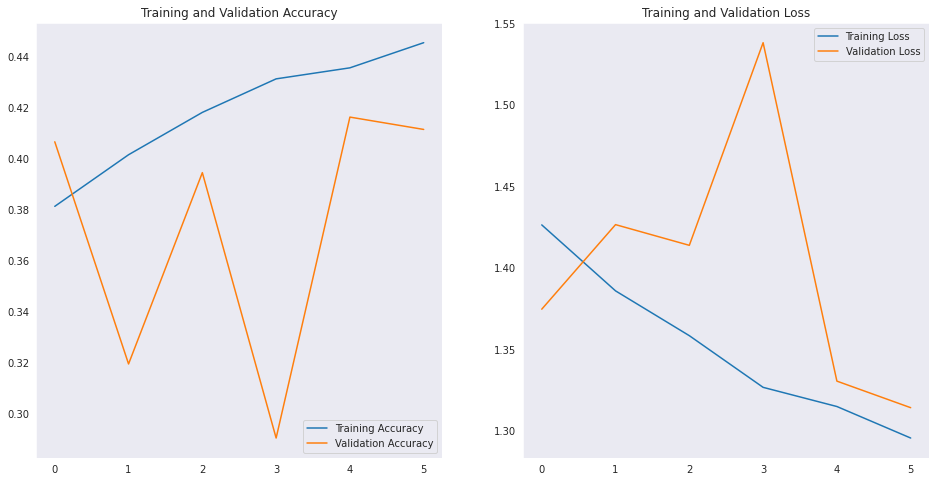

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4.3 Predictions on test set

In [34]:
all_predictions = []
y_pred = []
y_test = []
test_image_sample = None
first_batch = True

for image_batch, label_batch in test_dataset:
    predictions = model.predict(image_batch)
    all_predictions.append(predictions)
    y_pred.append(predictions.argmax(axis=1))
    if first_batch:
        test_image_sample = image_batch.numpy()
        first_batch = False
    y_test.append(label_batch)

In [35]:
predicted_labels = tf.concat([item for item in y_pred], axis=0)
true_labels = tf.concat([item for item in y_test], axis=0)
predictions = tf.concat([item for item in all_predictions],axis=0)

#### 4.3.1 Model accuracy

In [36]:
accuracy_score = 100 * np.sum(predicted_labels.numpy() == true_labels.numpy())/len(predictions)
print('Accuracy of model: {:.2f} percent'.format(accuracy_score))

Accuracy of model: 41.91 percent


#### 4.3.2 Confusion matrix

In [37]:
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[540,  10,  78,  11,   0],
       [249,   9,  36,   2,   0],
       [292,  16, 112,  26,   1],
       [120,  13,  56,  32,   2],
       [ 20,   1,  15,  14,   1]])

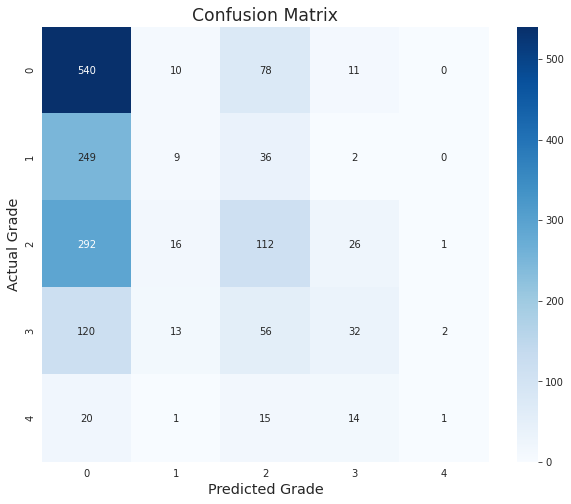

In [41]:
plt.figure(figsize=(10, 8))
_ = sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')
plt.xlabel('Predicted Grade', size='x-large')
plt.ylabel('Actual Grade', size='x-large')
_ = plt.title('Confusion Matrix',size='xx-large')

#### 4.3.3 Classification Report

In [39]:
clr = classification_report(true_labels, predicted_labels, zero_division=0)
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.44      0.85      0.58       639
           1       0.18      0.03      0.05       296
           2       0.38      0.25      0.30       447
           3       0.38      0.14      0.21       223
           4       0.25      0.02      0.04        51

    accuracy                           0.42      1656
   macro avg       0.33      0.26      0.24      1656
weighted avg       0.36      0.42      0.34      1656



#### 4.3.4 Sample images from test set

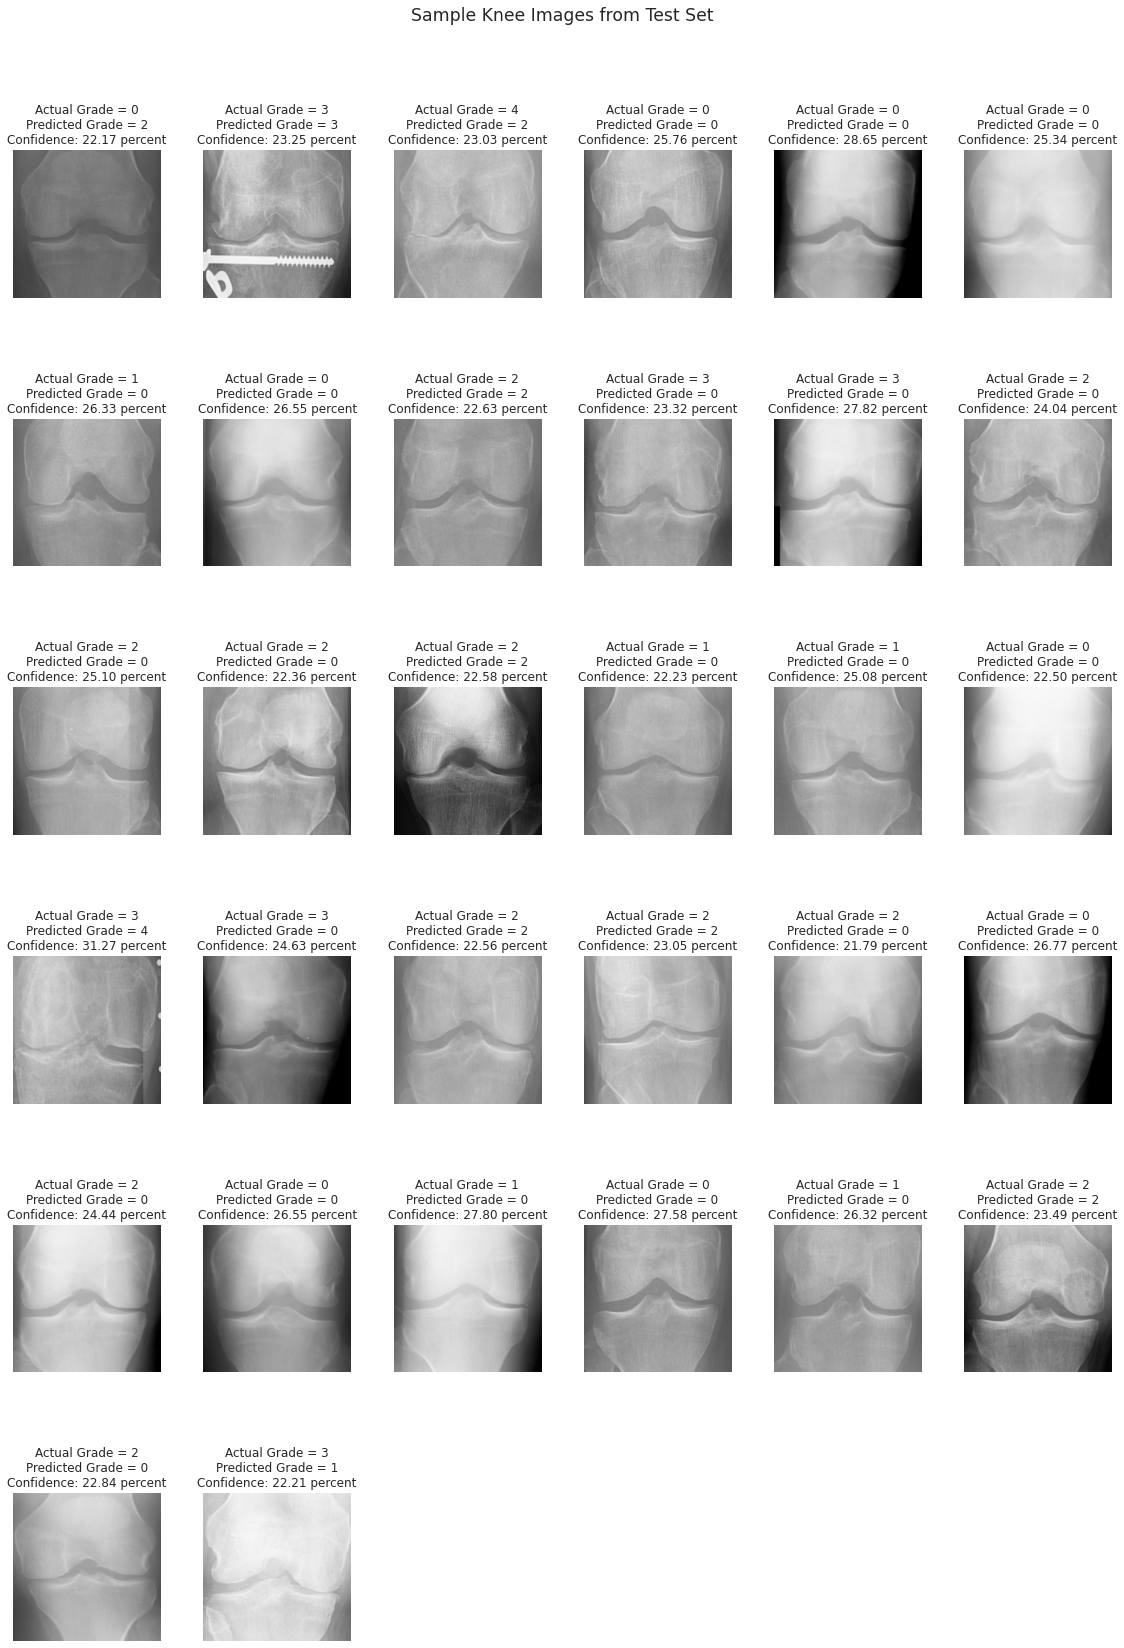

In [40]:
plt.figure(figsize=(16, 25))

for img_num in range(len(test_image_sample)):
    ax = plt.subplot(6,6,img_num+1)
    ax.axis('off')
    plt.imshow(test_image_sample[img_num].squeeze().astype('uint8'))
    actual_grade = true_labels[img_num].numpy()
    pred_grade = predicted_labels[img_num].numpy()
    score = 100*np.max(tf.nn.softmax(predictions[img_num]))
    title = "Actual Grade = {}\nPredicted Grade = {}\nConfidence: {:.2f} percent".format(actual_grade, pred_grade, score)
    ax.set_title(title) 
_ = plt.suptitle('Sample Knee Images from Test Set', size='xx-large')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])